In [1]:
%matplotlib inline
import numpy as np
import os
import time
import h5py
import keras
import pandas as pd
import math
import joblib
import json
import matplotlib.pyplot as plt
from scipy.stats import logistic

from IPython.display import display

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from keras.layers import (Input, Dense, Lambda, Flatten, Reshape, BatchNormalization, 
                          Activation, Dropout, Conv2D, Conv2DTranspose,
                          Concatenate, Add, Multiply)
from keras.engine import InputSpec
from keras.losses import sparse_categorical_crossentropy
from keras.optimizers import RMSprop, Adam
from keras.models import Model
from keras.utils import to_categorical
from keras.regularizers import l2
from keras import metrics
from keras import backend as K
from keras_tqdm import TQDMNotebookCallback
from keras.datasets import cifar10

import tensorflow as tf

/home/brian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Parameters

In [70]:
img_rows, img_cols, img_chns = 32, 32, 3
original_img_size = (img_rows, img_cols, img_chns)
sample = 1

batch_size = int(os.environ.get('BATCH_SIZE', 2))
epochs = int(os.environ.get('EPOCHS', 1000))
activation = os.environ.get('ACTIVATION', 'relu')
learning_rate = float(os.environ.get('LEARNING_RATE', 0.001))
resnet_depth = int(os.environ.get('RESNET_DEPTH', 4))
mixture_components = int(os.environ.get('MIXTURE_COMPONENTS', 1))

# Load CIFAR10 dataset

In [71]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

#crop = (32 - img_rows) // 2
#X_train = X_train[:sample, crop:-crop, crop:-crop, :]
X_train = X_train[:sample, :, :, :]
X_train = X_train / 255.
#X_train_out = X_train.reshape((X_train.shape[0], -1))

X_test = X_test / 255.
#X_test_out = X_test.reshape((X_test.shape[0], -1))

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

#print(X_train.shape, X_train_out.shape, y_train.shape)
#print(X_test.shape, X_test_out.shape, y_test.shape)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1, 32, 32, 3) (50000, 10)
(10000, 32, 32, 3) (10000, 10)


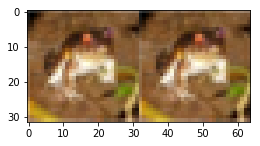

In [72]:
n = min(sample, 10)
figure = np.zeros((img_rows * n, img_cols * 2, img_chns))
for i in range(n):
    orig_img = X_train[i] 
    dy = img_rows * i
    figure[dy:dy + img_rows, :img_cols] = orig_img
    
    # Digitize
    img = (orig_img * 255.).astype(float) / 255
    figure[dy:dy + img_rows, img_cols:2 * img_cols] = img

plt.figure(figsize=(n * 4, 10))
plt.imshow(figure)
plt.show()

# Pixel CNN Helpers

In [73]:
class PixelConv2D(Conv2D):
    def __init__(self, ptype, *args, **kwargs):
        # ptype corresponds to pixel type and mask type, e.g. ra, ga, ba, rb, gb, bb
        assert ptype[0] in ['r', 'g', 'b'], ptype
        assert ptype[1] in ['a', 'b'], ptype
        self.ptype = ptype
        super(PixelConv2D, self).__init__(*args, **kwargs)
       
    def build_mask(self, kernel_shape):
        # kernel_shape = kern_dim x kern_dim x total_filters
        #              = kern_dim x kern_dim x r_g_b_filters x filters_per_channel
        assert kernel_shape[0] == kernel_shape[1], "{} must be equal in first two dims".format(kernel_shape)
        assert kernel_shape[0] % 2 == 1, "{} must be odd size in first two dims".format(kernel_shape)
        assert kernel_shape[2] % 3 == 0, "{} must be divisible by 3".format(kernel_shape)
        data = np.ones(kernel_shape)
        
        data.shape
        mid = data.shape[0] // 2
        if self.ptype[0] == 'r':
            filt_prev = 0
            filt_thres = int(data.shape[2] / 3)
        elif self.ptype[0] == 'g':
            filt_prev = int(data.shape[2] / 3)
            filt_thres = int(2 * data.shape[2] / 3)
        else:
            assert self.ptype[0] == 'b', self.ptype
            filt_prev = int(2 * data.shape[2] / 3)
            filt_thres = data.shape[2]
            
        # print(data.shape, self.ptype, mid, filt_prev, filt_thres)
        
        for k1 in range(data.shape[0]):
            for k2 in range(data.shape[1]):
                for chan in range(data.shape[2]):
                    #for filt in range(data.shape[3]):
                    if (self.ptype[1] == 'a' and filt_prev <= chan < filt_thres and k1 == mid and k2 == mid):
                        data[k1, k2, chan, :] = 0
                        #if k1 > mid or (k1 >= mid and k2 >= mid) or chan >= filt_thres:
                    elif k1 > mid or (k1 >= mid and k2 > mid) or chan >= filt_thres:
                        data[k1, k2, chan, :] = 0
            
        return K.constant(np.ravel(data), dtype='float32', shape=kernel_shape)
       
    def build(self, input_shape):
        if self.data_format == 'channels_first':
            channel_axis = 1
        else:
            channel_axis = -1
        if input_shape[channel_axis] is None:
            raise ValueError('The channel dimension of the inputs '
                             'should be defined. Found `None`.')
        input_dim = input_shape[channel_axis]
        kernel_shape = self.kernel_size + (input_dim, self.filters)
        
        self.kernel_mask = self.build_mask(kernel_shape)
        self.kernel = self.add_weight(shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.filters,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        # Set input spec.
        self.input_spec = InputSpec(ndim=self.rank + 2,
                                    axes={channel_axis: input_dim})
        self.built = True

    def call(self, inputs):
        masked_kernel = self.kernel * self.kernel_mask
        outputs = K.conv2d(
            inputs,
            masked_kernel,
            strides=self.strides,
            padding=self.padding,
            data_format=self.data_format,
            dilation_rate=self.dilation_rate)

        if self.use_bias:
            outputs = K.bias_add(
                outputs,
                self.bias,
                data_format=self.data_format)

        if self.activation is not None:
            return self.activation(outputs)
        
        return outputs

# Model

In [90]:
if K.image_data_format() == 'channels_last':
    bn_axis = 3
else:
    bn_axis = 1
    
def conv_block(input_tensor, filters, kernel_size, name, is_first=False):
    outs = []
    for t in ['rb', 'gb', 'bb']:
        if is_first:
            t = t[0] + 'a'
        x = PixelConv2D(t, filters, kernel_size, name='res' + name + t, padding='same')(input_tensor)
        # TODO FIX ME
        # TODO FIX ME
        # TODO FIX ME
        # TODO FIX ME
        # TODO FIX ME
        #x = Conv2D(filters, kernel_size, name='res' + name + t, padding='same')(input_tensor)
        # x = BatchNormalization(axis=bn_axis, name='bn' + name + t)(x)
        x = Activation('relu')(x)
        outs.append(x)
        
    return Concatenate()(outs)

def resnet_block(input_tensor, filters, stage, block):
    name_base = str(stage) + block + '_branch'
    filters1, filters2, filters3 = filters
    x = input_tensor
    x = conv_block(x, filters1, (1, 1), name=name_base + '2a')
    x = conv_block(x, filters2, (3, 3), name=name_base + '2b')
    x = conv_block(x, filters3, (1, 1), name=name_base + '2c')
    x = Add()([x, input_tensor])
    
    return x

def final_block(input_tensor, filters, in_filters, name, kernel_size=(1, 1)):
    outs = []
    channel_name = 'rgb'
    for channel in range(img_chns):
        # Only allow things behind it...
        x = Lambda(lambda x: x[:, :, :, :(channel + 1) * in_filters])(input_tensor)
        x = Conv2D(filters, kernel_size, name='final' + name + channel_name[channel], padding='same')(x)
        # x = BatchNormalization(axis=bn_axis, name='bn' + name + t)(x)
        x = Activation('relu')(x)
        outs.append(x)
        
    return Concatenate()(outs)

def build_outputs(input_tensor, final_filters):
    m_outs = []
    invs_outs = []
    weights = []
    for channel in range(img_chns):
        # Only allow things behind it...
        x = Lambda(lambda x: x[:, :, :, :(channel + 1) * final_filters])(input_tensor)
        decoder_out_m = Conv2D(name='x_m' + str(channel), filters=mixture_components, kernel_size=1, 
                               strides=1, activation='sigmoid')(x)
        decoder_out_invs_ = Conv2D(name='x_s' + str(channel), filters=mixture_components, kernel_size=1,
                                   strides=1, activation='sigmoid')(x)
        decoder_out_invs = Lambda(lambda x: 7. * x + 3.0)(decoder_out_invs_)
        mixture_weights = Conv2D(name='weights' + str(channel), filters=mixture_components, kernel_size=1,
                                 strides=1, activation='softmax')(x)
        m_outs.append(decoder_out_m)
        invs_outs.append(decoder_out_invs)
        weights.append(mixture_weights)
    
    out_m = Concatenate()(m_outs)       
    out_invs = Concatenate()(invs_outs)       
    out_mixture = Concatenate()(weights)       
    return Concatenate()([out_m, out_invs, out_mixture])

In [91]:
def pixelcnn_loss(target, output):
    # return sparse_categorical_crossentropy(target, output)
    # Note: tf.nn.sparse_softmax_cross_entropy_with_logits
    # expects logits, Keras expects probabilities.
    # _epsilon = tf.convert_to_tensor(K.epsilon(), output.dtype.base_dtype)
    # output = tf.clip_by_value(output, _epsilon, 1 - _epsilon)
    # output = tf.log(output)
    
    # print(target.shape, output.shape)
    # output_shape = output.get_shape()
    #targets = tf.cast(target, 'int64')
    #targets = tf.reshape(targets, (-1,))
    # logits = tf.reshape(output, [-1, int(output_shape[-1])])
    #res = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=targets, logits=output)
    #return tf.reduce_mean(res)
    
    
    # TODO KEEP EVERYTHING in 32,32,3 shape so that it's easier to compute,
    # especially the logsumexp(), right now I must be summing pixels together, when
    # I really should be summing across mixture components PER pixel.
    
    output_m = output[:, :, :, :3*mixture_components]
    output_invs = output[:, :, :, 3*mixture_components:6*mixture_components]
    output_mixture = output[:, :, :, 6*mixture_components:]
    
    #target_ = K.batch_flatten(target)
    targets = []
    #stride = img_rows * img_cols
    for chn in range(img_chns):
        targets += [target[:, :, :, chn]] * mixture_components
    x = K.concatenate(targets, axis=-1)
    x = K.reshape(x, (-1, img_rows, img_cols, img_chns * mixture_components))
    
    #x_decoded_m = K.batch_flatten(output_m)
    #x_decoded_invs = K.batch_flatten(output_invs)
    #x_weights = K.batch_flatten(output_mixture)
    x_decoded_m = output_m
    x_decoded_invs = output_invs
    x_weights = output_mixture
   
    offset = 1. / 255. / 2.
    centered_mean = x - x_decoded_m
    cdfminus_arg = (centered_mean - offset) * K.exp(x_decoded_invs)
    cdfplus_arg = (centered_mean + offset) * K.exp(x_decoded_invs)
                   
    cdfminus_safe = K.sigmoid(cdfminus_arg)
    cdfplus_safe = K.sigmoid(cdfplus_arg)
  
    # ln (sigmoid(x)) = x - ln(e^x + 1) = x - softplus(x)
    log_cdfplus = cdfplus_arg - K.tf.nn.softplus(cdfplus_arg)
    log_1minus_cdf = -K.tf.nn.softplus(cdfminus_arg)
    log_ll = K.tf.where(x <= 0.001, log_cdfplus,
                        K.tf.where(x >= 0.999, log_1minus_cdf,
                                   K.log(K.maximum(cdfplus_safe - cdfminus_safe, 1e-10))))
    
    # x_weights * [sigma(x+0.5...) - sigma(x-0.5 ...) ]
    # = log x_weights + log (...)
    pre_result = K.log(x_weights) + log_ll
    
    result = []
    for chn in range(img_chns):
        chn_result = pre_result[:, :, :, chn*mixture_components:(chn+1)*mixture_components]
        v = K.logsumexp(chn_result, axis=-1)
        result.append(v)
    result = K.batch_flatten(K.stack(result, axis=-1))
    return -K.sum(result, axis=-1)


def dummy_loss(target, output):
    output_m = output[:, :, :, :3*mixture_components]
    output_invs = output[:, :, :, 3*mixture_components:6*mixture_components]
    output_mixture = output[:, :, :, 6*mixture_components:]
    
    #target_ = K.batch_flatten(target)
    targets = []
    #stride = img_rows * img_cols
    for chn in range(img_chns):
        targets += [target[:, :, :, chn]] * mixture_components
    x = K.concatenate(targets, axis=-1)
    x = K.reshape(x, (-1, img_rows, img_cols, img_chns * mixture_components))
    
    return K.sum((x - output_m)*(x - output_m))

In [92]:
print("Building conv layers...")
main_input = Input(shape=original_img_size, name='main_input')

x = conv_block(main_input, 256, (7, 7), name='conv1', is_first=True)

for stage in range(resnet_depth):
    x = resnet_block(x, [128, 128, 256], stage, 'a')

final_width = 1024
x = final_block(x, final_width, 256, '1x1_1000_1')
x = final_block(x, final_width, final_width, '1x1_1000_2')

print("Building output layers...")
outputs = build_outputs(x, final_width)
main_output = outputs

print("Building model...")
model = Model(inputs=main_input, outputs=main_output)
optimizer = Adam(lr=0.001)
model.compile(optimizer=optimizer, loss=pixelcnn_loss)
#model.compile(optimizer=optimizer, loss=dummy_loss)
model.summary()

Building conv layers...
Building output layers...
Building model...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
resconv1ra (PixelConv2D)        (None, 32, 32, 256)  37888       main_input[0][0]                 
__________________________________________________________________________________________________
resconv1ga (PixelConv2D)        (None, 32, 32, 256)  37888       main_input[0][0]                 
__________________________________________________________________________________________________
resconv1ba (PixelConv2D)        (None, 32, 32, 256)  37888       main_input[0][0]                 
_________________________________________

In [93]:
start = time.time()

early_stopping = keras.callbacks.EarlyStopping('loss', min_delta=1.0, patience=20)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=10, min_lr=0.01 * learning_rate)
#early_stopping = keras.callbacks.EarlyStopping('val_loss', min_delta=0.1, patience=10)
#reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.001 * learning_rate)

#history = model.fit_generator(
#    data_generator(X_train, X_train_out, batch_size),
#    #batch_size=batch_size,
#    epochs=epochs,
#    steps_per_epoch=len(X_train) // batch_size,
#    callbacks=[TQDMNotebookCallback(), early_stopping, reduce_lr],
#    validation_data=data_generator(X_test, X_test_out, batch_size),
#    validation_steps=len(X_test) // batch_size,
#    max_queue_size=32,
#    #verbose=2
#)

history = model.fit(
    #X_train, X_train_out,
    X_train, X_train,
    batch_size=batch_size,
    #epochs=epochs,
    epochs=30,
    callbacks=[TQDMNotebookCallback()],#, early_stopping, reduce_lr],
    #validation_data=(X_test, X_test_out),
    verbose=0
)


done = time.time()
elapsed = done - start
print("Elapsed: ", elapsed)


Elapsed:  16.989577531814575


,loss
count,30.000000
mean,31992.349935
std,10351.783362
min,25106.619141
0%,25106.619141
25%,27633.215820
50%,28043.146484
75%,30864.674805
95%,57452.193555
99%,67734.003867


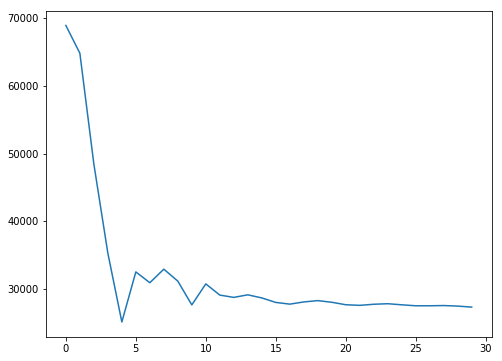

In [94]:
df = pd.DataFrame(history.history)
display(df.describe(percentiles=[0.25 * i for i in range(4)] + [0.95, 0.99]))
df['loss'].plot(figsize=(8, 6))

In [95]:
lossvals = model.evaluate(X_train, X_train)
print(lossvals)

1/1 [==============================] - 4s 4s/step
27251.248046875


In [96]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def compute_pvals(m, invs):
    # TODO FIX ME when adding more mixtures
    pvals = []
    for i in range(256):
        if i == 0:
            pval = logistic.cdf(0.5 / 255., loc=m, scale=1. / np.exp(invs))
        elif i == 255:
            pval = 1. - logistic.cdf(254.5 / 255., loc=m, scale=1. / np.exp(invs))
        else:
            pval = (logistic.cdf(i / 255. + 0.5 / 255., loc=m, scale=1. / np.exp(invs))
                    - logistic.cdf(i / 255. - 0.5 / 255., loc=m, scale=1. / np.exp(invs)))
        pvals.append(pval)
    
    return pvals

def compute_mixture(ms, invs, weights):
    components = []
    for i in range(mixture_components):
        components.append(weights[i] * np.array(compute_pvals(ms[i], invs[i])))
    return np.sum(components, axis=0)

In [97]:
debug = True

def gen_image(model, num_samples=batch_size):
    x_sample = np.zeros((num_samples, img_rows, img_cols, img_chns))
    
    # Iteratively generate each conditional pixel P(x_i | x_{1,..,i-1})
    for i in range(img_rows):
        for j in range(img_cols):
            for k in range(img_chns):
                x_out = model.predict(x_sample, num_samples)
                for n in range(num_samples):
                    offset = k * mixture_components
                    x_ms = x_out[n, i, j, offset:offset + mixture_components]
                    offset = mixture_components * img_chns + k * mixture_components
                    x_invs = x_out[n, i, j, offset:offset + mixture_components]
                    offset = 2 * mixture_components * img_chns + k * mixture_components
                    weights = x_out[n, i, j, offset:offset + mixture_components]
                    pvals = compute_mixture(x_ms, x_invs, weights)
                    pvals /= (np.sum(pvals) + 1e-5)
                    pixel_val = np.argmax(np.random.multinomial(1, pvals))
                    x_sample[n, i, j, k] = pixel_val / 255.
                    if 0 <= i <= 16 and 0 <= j <= 16 and debug:
                        print("====", i, j, k)
                        print(" m: ", x_ms)
                        print(" invs: ", x_invs)
                        print(" weights: ", weights)
                        print(" pixel_val: ", pixel_val)
                        #print(" x_out[n, i, j, :]: ", x_out[n, i, j, :])
                        #print(" x_out: ", x_out)
                        #print(" sample_val: ", x_sample[n, i, j, k])
                        #print(" pvals: ", pvals)
                        #assert False
        if debug:
            print("row", i)
                
    return x_sample


start = time.time()

n = 1 if debug else 10
figure = np.zeros((img_rows * ((n - 1) // 10 + 1), img_cols * 10, img_chns))
print(figure.shape)
for i in range(n):
    samples = gen_image(model)
    for j in range(batch_size):
        img = samples[j] 
        d_x = ((i * batch_size + j) // 10) * img_rows
        d_y = ((i * batch_size + j) % 10) * img_cols
        figure[d_x:d_x + img_rows, d_y:d_y + img_cols, :] = img
        
plt.figure(figsize=(12, 12))
plt.imshow(figure)
plt.show()

done = time.time()
elapsed = done - start
print("Elapsed: ", elapsed)

(32, 320, 3)
==== 0 0 0
 m:  [0.42675054]
 invs:  [3.1495366]
 weights:  [1.]
 pixel_val:  117
==== 0 0 0
 m:  [0.42675054]
 invs:  [3.1495366]
 weights:  [1.]
 pixel_val:  76
==== 0 0 1
 m:  [0.40458074]
 invs:  [3.0375986]
 weights:  [1.]
 pixel_val:  117
==== 0 0 1
 m:  [0.40456882]
 invs:  [3.0386074]
 weights:  [1.]
 pixel_val:  99
==== 0 0 2
 m:  [0.93537277]
 invs:  [3.0003545]
 weights:  [1.]
 pixel_val:  230
==== 0 0 2
 m:  [0.9331444]
 invs:  [3.0004063]
 weights:  [1.]
 pixel_val:  235
==== 0 1 0
 m:  [0.41366547]
 invs:  [3.081931]
 weights:  [1.]
 pixel_val:  94
==== 0 1 0
 m:  [0.41642335]
 invs:  [3.0942965]
 weights:  [1.]
 pixel_val:  91
==== 0 1 1
 m:  [0.38833043]
 invs:  [3.0160744]
 weights:  [1.]
 pixel_val:  85
==== 0 1 1
 m:  [0.39160454]
 invs:  [3.01989]
 weights:  [1.]
 pixel_val:  71
==== 0 1 2
 m:  [0.95784116]
 invs:  [3.000057]
 weights:  [1.]
 pixel_val:  244
==== 0 1 2
 m:  [0.9528987]
 invs:  [3.0000906]
 weights:  [1.]
 pixel_val:  255
==== 0 2 0
 m: 

row 0
==== 1 0 0
 m:  [0.4082219]
 invs:  [3.0440037]
 weights:  [1.]
 pixel_val:  110
==== 1 0 0
 m:  [0.40979433]
 invs:  [3.0475492]
 weights:  [1.]
 pixel_val:  119
==== 1 0 1
 m:  [0.3842029]
 invs:  [3.0061088]
 weights:  [1.]
 pixel_val:  142
==== 1 0 1
 m:  [0.38575047]
 invs:  [3.0068588]
 weights:  [1.]
 pixel_val:  97
==== 1 0 2
 m:  [0.98232746]
 invs:  [3.0000024]
 weights:  [1.]
 pixel_val:  255
==== 1 0 2
 m:  [0.9810271]
 invs:  [3.0000033]
 weights:  [1.]
 pixel_val:  238
==== 1 1 0
 m:  [0.38839686]
 invs:  [3.0180397]
 weights:  [1.]
 pixel_val:  120
==== 1 1 0
 m:  [0.38966715]
 invs:  [3.0192935]
 weights:  [1.]
 pixel_val:  137
==== 1 1 1
 m:  [0.3574302]
 invs:  [3.0016475]
 weights:  [1.]
 pixel_val:  100
==== 1 1 1
 m:  [0.3596982]
 invs:  [3.001846]
 weights:  [1.]
 pixel_val:  63
==== 1 1 2
 m:  [0.99288344]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  253
==== 1 1 2
 m:  [0.9921077]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  245
==== 1 2 0
 m:  [0.3730888]
 invs

==== 2 0 1
 m:  [0.40681162]
 invs:  [3.0053072]
 weights:  [1.]
 pixel_val:  135
==== 2 0 1
 m:  [0.40470287]
 invs:  [3.0040872]
 weights:  [1.]
 pixel_val:  70
==== 2 0 2
 m:  [0.99022233]
 invs:  [3.0000002]
 weights:  [1.]
 pixel_val:  249
==== 2 0 2
 m:  [0.9914586]
 invs:  [3.0000002]
 weights:  [1.]
 pixel_val:  255
==== 2 1 0
 m:  [0.40842113]
 invs:  [3.0240357]
 weights:  [1.]
 pixel_val:  113
==== 2 1 0
 m:  [0.4035665]
 invs:  [3.0170944]
 weights:  [1.]
 pixel_val:  80
==== 2 1 1
 m:  [0.3866673]
 invs:  [3.0018268]
 weights:  [1.]
 pixel_val:  107
==== 2 1 1
 m:  [0.38190603]
 invs:  [3.0012212]
 weights:  [1.]
 pixel_val:  119
==== 2 1 2
 m:  [0.996476]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  255
==== 2 1 2
 m:  [0.9970746]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  255
==== 2 2 0
 m:  [0.39161196]
 invs:  [3.0122569]
 weights:  [1.]
 pixel_val:  89
==== 2 2 0
 m:  [0.38464835]
 invs:  [3.0096133]
 weights:  [1.]
 pixel_val:  105
==== 2 2 1
 m:  [0.36381873]
 invs:  [3

==== 3 1 0
 m:  [0.42657837]
 invs:  [3.0345292]
 weights:  [1.]
 pixel_val:  95
==== 3 1 0
 m:  [0.42574754]
 invs:  [3.02882]
 weights:  [1.]
 pixel_val:  111
==== 3 1 1
 m:  [0.414522]
 invs:  [3.0022557]
 weights:  [1.]
 pixel_val:  111
==== 3 1 1
 m:  [0.4139626]
 invs:  [3.0017695]
 weights:  [1.]
 pixel_val:  95
==== 3 1 2
 m:  [0.9982002]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  219
==== 3 1 2
 m:  [0.9984836]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  233
==== 3 2 0
 m:  [0.4124624]
 invs:  [3.0180798]
 weights:  [1.]
 pixel_val:  63
==== 3 2 0
 m:  [0.4053594]
 invs:  [3.0139577]
 weights:  [1.]
 pixel_val:  105
==== 3 2 1
 m:  [0.39421046]
 invs:  [3.0007427]
 weights:  [1.]
 pixel_val:  73
==== 3 2 1
 m:  [0.3845783]
 invs:  [3.0005424]
 weights:  [1.]
 pixel_val:  107
==== 3 2 2
 m:  [0.999363]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  255
==== 3 2 2
 m:  [0.9994423]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  255
==== 3 3 0
 m:  [0.394846]
 invs:  [3.0088778]
 weights:  [1.

==== 4 1 1
 m:  [0.4227229]
 invs:  [3.0035932]
 weights:  [1.]
 pixel_val:  77
==== 4 1 1
 m:  [0.4246385]
 invs:  [3.002276]
 weights:  [1.]
 pixel_val:  96
==== 4 1 2
 m:  [0.99800724]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  254
==== 4 1 2
 m:  [0.99865973]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  238
==== 4 2 0
 m:  [0.4249506]
 invs:  [3.0270395]
 weights:  [1.]
 pixel_val:  160
==== 4 2 0
 m:  [0.40966904]
 invs:  [3.0159063]
 weights:  [1.]
 pixel_val:  105
==== 4 2 1
 m:  [0.41180566]
 invs:  [3.001188]
 weights:  [1.]
 pixel_val:  172
==== 4 2 1
 m:  [0.39199337]
 invs:  [3.0005946]
 weights:  [1.]
 pixel_val:  105
==== 4 2 2
 m:  [0.9994067]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  255
==== 4 2 2
 m:  [0.9995735]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  244
==== 4 3 0
 m:  [0.40833354]
 invs:  [3.0132368]
 weights:  [1.]
 pixel_val:  89
==== 4 3 0
 m:  [0.38954496]
 invs:  [3.0070913]
 weights:  [1.]
 pixel_val:  98
==== 4 3 1
 m:  [0.3879049]
 invs:  [3.000364]
 weights

==== 5 1 2
 m:  [0.99847394]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  250
==== 5 1 2
 m:  [0.9987287]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  230
==== 5 2 0
 m:  [0.42306334]
 invs:  [3.0249574]
 weights:  [1.]
 pixel_val:  93
==== 5 2 0
 m:  [0.41605595]
 invs:  [3.020228]
 weights:  [1.]
 pixel_val:  143
==== 5 2 1
 m:  [0.41014415]
 invs:  [3.0010333]
 weights:  [1.]
 pixel_val:  116
==== 5 2 1
 m:  [0.40057272]
 invs:  [3.000761]
 weights:  [1.]
 pixel_val:  98
==== 5 2 2
 m:  [0.99949753]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  255
==== 5 2 2
 m:  [0.99957544]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  239
==== 5 3 0
 m:  [0.40884134]
 invs:  [3.0138767]
 weights:  [1.]
 pixel_val:  107
==== 5 3 0
 m:  [0.39497066]
 invs:  [3.0080554]
 weights:  [1.]
 pixel_val:  73
==== 5 3 1
 m:  [0.38891503]
 invs:  [3.0003612]
 weights:  [1.]
 pixel_val:  130
==== 5 3 1
 m:  [0.36997932]
 invs:  [3.0001764]
 weights:  [1.]
 pixel_val:  90
==== 5 3 2
 m:  [0.9998258]
 invs:  [3.]
 weights: 

==== 6 2 1
 m:  [0.4093945]
 invs:  [3.0009372]
 weights:  [1.]
 pixel_val:  102
==== 6 2 1
 m:  [0.40490434]
 invs:  [3.0007355]
 weights:  [1.]
 pixel_val:  78
==== 6 2 2
 m:  [0.99955374]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  250
==== 6 2 2
 m:  [0.99961346]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  255
==== 6 3 0
 m:  [0.40384677]
 invs:  [3.0136833]
 weights:  [1.]
 pixel_val:  108
==== 6 3 0
 m:  [0.40017033]
 invs:  [3.0098248]
 weights:  [1.]
 pixel_val:  108
==== 6 3 1
 m:  [0.382625]
 invs:  [3.0003638]
 weights:  [1.]
 pixel_val:  95
==== 6 3 1
 m:  [0.378012]
 invs:  [3.0002177]
 weights:  [1.]
 pixel_val:  95
==== 6 3 2
 m:  [0.99982315]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  247
==== 6 3 2
 m:  [0.9998734]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  247
==== 6 4 0
 m:  [0.39941898]
 invs:  [3.0114257]
 weights:  [1.]
 pixel_val:  108
==== 6 4 0
 m:  [0.39950165]
 invs:  [3.009244]
 weights:  [1.]
 pixel_val:  99
==== 6 4 1
 m:  [0.37524185]
 invs:  [3.0002842]
 weigh

==== 7 3 0
 m:  [0.40122384]
 invs:  [3.0126333]
 weights:  [1.]
 pixel_val:  122
==== 7 3 0
 m:  [0.40105057]
 invs:  [3.011119]
 weights:  [1.]
 pixel_val:  117
==== 7 3 1
 m:  [0.37856507]
 invs:  [3.000305]
 weights:  [1.]
 pixel_val:  63
==== 7 3 1
 m:  [0.3786801]
 invs:  [3.0002427]
 weights:  [1.]
 pixel_val:  87
==== 7 3 2
 m:  [0.9998435]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  255
==== 7 3 2
 m:  [0.99987006]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  255
==== 7 4 0
 m:  [0.39729428]
 invs:  [3.0106592]
 weights:  [1.]
 pixel_val:  68
==== 7 4 0
 m:  [0.39997023]
 invs:  [3.0106807]
 weights:  [1.]
 pixel_val:  79
==== 7 4 1
 m:  [0.37329793]
 invs:  [3.000252]
 weights:  [1.]
 pixel_val:  109
==== 7 4 1
 m:  [0.37701514]
 invs:  [3.000243]
 weights:  [1.]
 pixel_val:  92
==== 7 4 2
 m:  [0.99986565]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  230
==== 7 4 2
 m:  [0.9998758]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  255
==== 7 5 0
 m:  [0.39959624]
 invs:  [3.0111954]
 weight

==== 8 3 2
 m:  [0.9998435]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  226
==== 8 3 2
 m:  [0.9998394]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  255
==== 8 4 0
 m:  [0.4005364]
 invs:  [3.0117066]
 weights:  [1.]
 pixel_val:  119
==== 8 4 0
 m:  [0.40230304]
 invs:  [3.012268]
 weights:  [1.]
 pixel_val:  112
==== 8 4 1
 m:  [0.37716207]
 invs:  [3.0003026]
 weights:  [1.]
 pixel_val:  110
==== 8 4 1
 m:  [0.3805649]
 invs:  [3.0003088]
 weights:  [1.]
 pixel_val:  94
==== 8 4 2
 m:  [0.9998462]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  235
==== 8 4 2
 m:  [0.9998553]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  255
==== 8 5 0
 m:  [0.40422702]
 invs:  [3.012033]
 weights:  [1.]
 pixel_val:  100
==== 8 5 0
 m:  [0.3995296]
 invs:  [3.0115023]
 weights:  [1.]
 pixel_val:  121
==== 8 5 1
 m:  [0.38261104]
 invs:  [3.0003047]
 weights:  [1.]
 pixel_val:  101
==== 8 5 1
 m:  [0.37616196]
 invs:  [3.0002785]
 weights:  [1.]
 pixel_val:  67
==== 8 5 2
 m:  [0.9998498]
 invs:  [3.]
 weights:  [1.

==== 9 4 1
 m:  [0.37197384]
 invs:  [3.0002275]
 weights:  [1.]
 pixel_val:  107
==== 9 4 1
 m:  [0.3737445]
 invs:  [3.0002604]
 weights:  [1.]
 pixel_val:  85
==== 9 4 2
 m:  [0.9998653]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  254
==== 9 4 2
 m:  [0.99985313]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  255
==== 9 5 0
 m:  [0.4045369]
 invs:  [3.0109782]
 weights:  [1.]
 pixel_val:  129
==== 9 5 0
 m:  [0.3961801]
 invs:  [3.010745]
 weights:  [1.]
 pixel_val:  89
==== 9 5 1
 m:  [0.38427067]
 invs:  [3.0002654]
 weights:  [1.]
 pixel_val:  90
==== 9 5 1
 m:  [0.37181374]
 invs:  [3.0002828]
 weights:  [1.]
 pixel_val:  83
==== 9 5 2
 m:  [0.99986553]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  236
==== 9 5 2
 m:  [0.9998392]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  255
==== 9 6 0
 m:  [0.40014005]
 invs:  [3.0100033]
 weights:  [1.]
 pixel_val:  91
==== 9 6 0
 m:  [0.39857647]
 invs:  [3.0105028]
 weights:  [1.]
 pixel_val:  90
==== 9 6 1
 m:  [0.37838528]
 invs:  [3.0002341]
 weight

==== 10 4 2
 m:  [0.9998808]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  255
==== 10 4 2
 m:  [0.99986434]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  237
==== 10 5 0
 m:  [0.40360877]
 invs:  [3.01076]
 weights:  [1.]
 pixel_val:  107
==== 10 5 0
 m:  [0.39624235]
 invs:  [3.0088427]
 weights:  [1.]
 pixel_val:  99
==== 10 5 1
 m:  [0.38293883]
 invs:  [3.0002594]
 weights:  [1.]
 pixel_val:  59
==== 10 5 1
 m:  [0.37251374]
 invs:  [3.0002098]
 weights:  [1.]
 pixel_val:  52
==== 10 5 2
 m:  [0.9998659]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  248
==== 10 5 2
 m:  [0.9998634]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  208
==== 10 6 0
 m:  [0.4011302]
 invs:  [3.010014]
 weights:  [1.]
 pixel_val:  93
==== 10 6 0
 m:  [0.39698285]
 invs:  [3.0086145]
 weights:  [1.]
 pixel_val:  114
==== 10 6 1
 m:  [0.37880376]
 invs:  [3.000244]
 weights:  [1.]
 pixel_val:  80
==== 10 6 1
 m:  [0.37412632]
 invs:  [3.0002022]
 weights:  [1.]
 pixel_val:  86
==== 10 6 2
 m:  [0.9998685]
 invs:  [3.]
 wei

==== 11 4 2
 m:  [0.9998673]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  255
==== 11 5 0
 m:  [0.39843655]
 invs:  [3.0085611]
 weights:  [1.]
 pixel_val:  83
==== 11 5 0
 m:  [0.39677945]
 invs:  [3.0083423]
 weights:  [1.]
 pixel_val:  95
==== 11 5 1
 m:  [0.37565017]
 invs:  [3.0001898]
 weights:  [1.]
 pixel_val:  112
==== 11 5 1
 m:  [0.3732729]
 invs:  [3.0001948]
 weights:  [1.]
 pixel_val:  87
==== 11 5 2
 m:  [0.999889]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  255
==== 11 5 2
 m:  [0.9998733]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  254
==== 11 6 0
 m:  [0.40127784]
 invs:  [3.0093641]
 weights:  [1.]
 pixel_val:  109
==== 11 6 0
 m:  [0.3991237]
 invs:  [3.0081072]
 weights:  [1.]
 pixel_val:  95
==== 11 6 1
 m:  [0.37958884]
 invs:  [3.0002108]
 weights:  [1.]
 pixel_val:  66
==== 11 6 1
 m:  [0.37743282]
 invs:  [3.00018]
 weights:  [1.]
 pixel_val:  83
==== 11 6 2
 m:  [0.99988246]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  255
==== 11 6 2
 m:  [0.99988544]
 invs:  [3.]
 we

==== 12 5 1
 m:  [0.3738612]
 invs:  [3.0001893]
 weights:  [1.]
 pixel_val:  128
==== 12 5 1
 m:  [0.36633235]
 invs:  [3.00015]
 weights:  [1.]
 pixel_val:  123
==== 12 5 2
 m:  [0.99989426]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  246
==== 12 5 2
 m:  [0.9998945]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  255
==== 12 6 0
 m:  [0.39907166]
 invs:  [3.0097458]
 weights:  [1.]
 pixel_val:  104
==== 12 6 0
 m:  [0.39975306]
 invs:  [3.00875]
 weights:  [1.]
 pixel_val:  85
==== 12 6 1
 m:  [0.37490174]
 invs:  [3.0002148]
 weights:  [1.]
 pixel_val:  119
==== 12 6 1
 m:  [0.37781915]
 invs:  [3.0001972]
 weights:  [1.]
 pixel_val:  91
==== 12 6 2
 m:  [0.99988365]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  230
==== 12 6 2
 m:  [0.9998845]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  247
==== 12 7 0
 m:  [0.3991731]
 invs:  [3.011433]
 weights:  [1.]
 pixel_val:  102
==== 12 7 0
 m:  [0.40401372]
 invs:  [3.0107877]
 weights:  [1.]
 pixel_val:  116
==== 12 7 1
 m:  [0.37576827]
 invs:  [3.00

==== 13 5 2
 m:  [0.9998982]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  255
==== 13 5 2
 m:  [0.99988604]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  255
==== 13 6 0
 m:  [0.3948899]
 invs:  [3.0090857]
 weights:  [1.]
 pixel_val:  90
==== 13 6 0
 m:  [0.39696473]
 invs:  [3.009289]
 weights:  [1.]
 pixel_val:  109
==== 13 6 1
 m:  [0.37033096]
 invs:  [3.000201]
 weights:  [1.]
 pixel_val:  99
==== 13 6 1
 m:  [0.37386248]
 invs:  [3.0002089]
 weights:  [1.]
 pixel_val:  58
==== 13 6 2
 m:  [0.9998847]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  255
==== 13 6 2
 m:  [0.99988186]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  255
==== 13 7 0
 m:  [0.39293098]
 invs:  [3.0090587]
 weights:  [1.]
 pixel_val:  98
==== 13 7 0
 m:  [0.39751333]
 invs:  [3.0098212]
 weights:  [1.]
 pixel_val:  108
==== 13 7 1
 m:  [0.36853096]
 invs:  [3.0002089]
 weights:  [1.]
 pixel_val:  99
==== 13 7 1
 m:  [0.37338746]
 invs:  [3.0002358]
 weights:  [1.]
 pixel_val:  90
==== 13 7 2
 m:  [0.9998746]
 invs:  [3.]
 

==== 14 5 2
 m:  [0.9998758]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  255
==== 14 6 0
 m:  [0.39858526]
 invs:  [3.0096529]
 weights:  [1.]
 pixel_val:  91
==== 14 6 0
 m:  [0.39609185]
 invs:  [3.0095499]
 weights:  [1.]
 pixel_val:  99
==== 14 6 1
 m:  [0.37476566]
 invs:  [3.000223]
 weights:  [1.]
 pixel_val:  103
==== 14 6 1
 m:  [0.3725299]
 invs:  [3.000227]
 weights:  [1.]
 pixel_val:  130
==== 14 6 2
 m:  [0.99987686]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  255
==== 14 6 2
 m:  [0.999871]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  255
==== 14 7 0
 m:  [0.40033677]
 invs:  [3.010832]
 weights:  [1.]
 pixel_val:  105
==== 14 7 0
 m:  [0.39683884]
 invs:  [3.009869]
 weights:  [1.]
 pixel_val:  119
==== 14 7 1
 m:  [0.37715098]
 invs:  [3.000265]
 weights:  [1.]
 pixel_val:  119
==== 14 7 1
 m:  [0.3726625]
 invs:  [3.0002365]
 weights:  [1.]
 pixel_val:  91
==== 14 7 2
 m:  [0.9998598]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  255
==== 14 7 2
 m:  [0.9998653]
 invs:  [3.]
 wei

==== 15 6 0
 m:  [0.39931908]
 invs:  [3.0099204]
 weights:  [1.]
 pixel_val:  105
==== 15 6 1
 m:  [0.37882906]
 invs:  [3.000241]
 weights:  [1.]
 pixel_val:  84
==== 15 6 1
 m:  [0.37711033]
 invs:  [3.0002391]
 weights:  [1.]
 pixel_val:  67
==== 15 6 2
 m:  [0.9998747]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  255
==== 15 6 2
 m:  [0.9998673]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  255
==== 15 7 0
 m:  [0.40439075]
 invs:  [3.0113895]
 weights:  [1.]
 pixel_val:  80
==== 15 7 0
 m:  [0.3995016]
 invs:  [3.0100684]
 weights:  [1.]
 pixel_val:  80
==== 15 7 1
 m:  [0.3835234]
 invs:  [3.000281]
 weights:  [1.]
 pixel_val:  81
==== 15 7 1
 m:  [0.37688503]
 invs:  [3.0002496]
 weights:  [1.]
 pixel_val:  83
==== 15 7 2
 m:  [0.99985814]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  248
==== 15 7 2
 m:  [0.99986327]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  255
==== 15 8 0
 m:  [0.40319324]
 invs:  [3.0113225]
 weights:  [1.]
 pixel_val:  131
==== 15 8 0
 m:  [0.4029522]
 invs:  [3.0101

==== 16 6 2
 m:  [0.9998648]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  227
==== 16 6 2
 m:  [0.9998348]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  218
==== 16 7 0
 m:  [0.40122443]
 invs:  [3.0102668]
 weights:  [1.]
 pixel_val:  115
==== 16 7 0
 m:  [0.40415886]
 invs:  [3.0111287]
 weights:  [1.]
 pixel_val:  102
==== 16 7 1
 m:  [0.37977266]
 invs:  [3.0002573]
 weights:  [1.]
 pixel_val:  125
==== 16 7 1
 m:  [0.38342616]
 invs:  [3.0002878]
 weights:  [1.]
 pixel_val:  74
==== 16 7 2
 m:  [0.9998641]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  255
==== 16 7 2
 m:  [0.9998511]
 invs:  [3.]
 weights:  [1.]
 pixel_val:  227
==== 16 8 0
 m:  [0.40172872]
 invs:  [3.0103421]
 weights:  [1.]
 pixel_val:  90
==== 16 8 0
 m:  [0.4037065]
 invs:  [3.010342]
 weights:  [1.]
 pixel_val:  83
==== 16 8 1
 m:  [0.38071206]
 invs:  [3.0002446]
 weights:  [1.]
 pixel_val:  97
==== 16 8 1
 m:  [0.38346583]
 invs:  [3.0002515]
 weights:  [1.]
 pixel_val:  48
==== 16 8 2
 m:  [0.99987197]
 invs:  [3.]


KeyboardInterrupt: 

In [ ]:
m = 0.354
invs = np.exp(2.52)
for i in range(0, 256):
    if i > 0 and i < 255:
        x = logistic.cdf(i / 255. + (1 / 255. / 2), loc=m, scale=1./invs)
        y = logistic.cdf(i / 255. - (1 / 255. / 2), loc=m, scale=1./invs)
        print(i, x-y)
    elif i == 0:
        x = logistic.cdf(i / 255. + (1 / 255. / 2), loc=m, scale=1./invs)
        print(i, x)
    elif i == 255:
        x = 1. - logistic.cdf(i / 255. - (1 / 255. / 2), loc=m, scale=1./invs)
        print(i, x)

In [ ]:
X_train[0, 0, 0, :] * 255

In [ ]:
plt.figure(figsize=(3, 3))
plt.imshow((255 * img).astype(int))
plt.show()

In [ ]:
img[12:16, 12:16, :]

In [ ]:
df = pd.DataFrame(samples.reshape(400,3))
df.describe()

In [ ]:
#if os.environ.get('OUTDIR', None):
#    encoder.save(os.path.join(os.environ['OUTDIR'], 'encoder-depth-' + str(resnet_depth) + '.h5'))
#    decoder.save(os.path.join(os.environ['OUTDIR'], 'decoder-depth-' + str(resnet_depth) + '.h5'))
#
#    vals = {k: v for k, v in locals().items() if type(v) in [int, float, bool]}
#    with open(os.path.join(os.environ['OUTDIR'], 'params-depth-' + str(resnet_depth) + '.json'), 'w') as f:
#        json.dump(vals, f)

In [ ]:
#data = np.ones([3, 3, 6, 1])
#
#data.shape
#ptype = 'ba'
#mid = data.shape[0] // 2
#if ptype[0] == 'r':
#    filt_prev = 0
#    filt_thres = int(data.shape[2] / 3)
#elif ptype[0] == 'g':
#    filt_prev = int(data.shape[2] / 3)
#    filt_thres = int(2 * data.shape[2] / 3)
#else:
#    filt_prev = int(2 * data.shape[2] / 3)
#    filt_thres = data.shape[2]
#    
#print(data.shape, ptype, mid, filt_prev, filt_thres)
#
#for k1 in range(data.shape[0]):
#    for k2 in range(data.shape[1]):
#        for chan in range(data.shape[2]):
#            for filt in range(data.shape[3]):
#                if ptype[1] == 'a' and chan >= filt_prev:
#                    if k1 > mid or (k1 >= mid and k2 >= mid) or chan >= filt_thres:
#                        data[k1, k2, chan, filt] = 0
#                else:
#                    if k1 > mid or (k1 >= mid and k2 > mid) or chan >= filt_thres:
#                        data[k1, k2, chan, filt] = 0
#    
#print(data[:, :, 0, 0])
#print(data[:, :, filt_thres-1, 0])
#data



#def data_generator(X_data, X_data_out, batch_size):
#    while True:
#        index = np.arange(len(X_data))
#        np.random.shuffle(index)
#        for i in range(len(X_data) // batch_size):
#            batch_in_data = X_data[index[i * batch_size: (i+1)*batch_size], :, :, :]
#            batch_out_data = X_data_out[index[i * batch_size: (i+1)*batch_size], :, :]
#            yield batch_in_data, to_categorical(batch_out_data, num_classes=256).reshape(batch_size, -1)
#            
#for x, y in data_generator(X_test, X_test_out, 1):
#    print(x.shape, y.shape)
#    break

# Notes

* Did the last conv layer wrong (did a masking layer, when I should have done a 1x1 on each channel) -- actually might want to actually do a type B mask on last layer...
* Debug using single image, then grow it
* GPU small, so cut down problem to 20x20x3; discretize outputs to 16 levels for each channel (vs. 256)
* Found the tensorflow loss function the best, didn't have to duplicate softmax, then call keras, which then converts back to a probability
* Don't need an explicit dense layer on output because loss function takes care of it for me.  Just use output of 1x1 conv directly.
